In [2]:
!pip install roboflow
!pip install inference-sdk
!pip install opencv-python
!pip install supervision


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Loaded 10000 images and 1000 classes (subjects) from CASIA Iris Dataset.


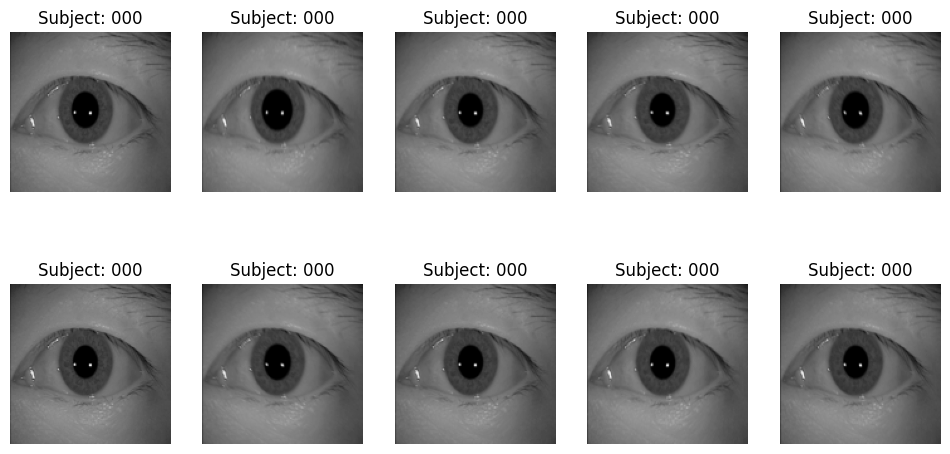

In [3]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def load_casia_dataset(dataset_path):
    X = []
    y = []
    label_encoder = LabelEncoder()
    subject_ids = []

    # Loop through dataset folders (each folder represents a subject)
    for subject_folder in os.listdir(dataset_path):
        subject_folder_path = os.path.join(dataset_path, subject_folder)
        if os.path.isdir(subject_folder_path):
            subject_id = subject_folder  # Use the folder name as the subject ID
            subject_ids.append(subject_id)
            
            # Check for image files in the subject folder
            image_files = [f for f in os.listdir(subject_folder_path) if f.endswith('.jpg')]  # Change this filter if needed
            if len(image_files) == 0:
                continue  # Skip if no valid image files found
            
            # Loop through images in the subject folder
            for image_file in image_files:
                image_path = os.path.join(subject_folder_path, image_file)
                img = Image.open(image_path).convert('L')  # Convert to grayscale
                img = img.resize((128, 128))  # Resize image to (128, 128)
                img_array = np.array(img) / 255.0  # Normalize pixel values to [0, 1]
                X.append(img_array)
                y.append(subject_id)
    
    if len(X) == 0:
        raise ValueError("No valid images found in the dataset.")
    
    X = np.array(X)
    y = label_encoder.fit_transform(np.array(y))
    
    return X, y, label_encoder

# Replace 'path_to_casia_dataset' with the actual path where you have extracted the CASIA Iris Dataset
dataset_path = r"C:\Iris Attendance CASIA"

# Check if the dataset path exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError(f"The specified dataset path does not exist: {dataset_path}")

X, y, label_encoder = load_casia_dataset(dataset_path)

print(f"Loaded {len(X)} images and {len(np.unique(y))} classes (subjects) from CASIA Iris Dataset.")

# Plot some sample images to confirm data has been read correctly
def plot_sample_images(X, y, label_encoder, num_samples=10):
    plt.figure(figsize=(12, 6))
    for i in range(min(num_samples, len(X))):  # Ensure we don't exceed available samples
        plt.subplot(2, 5, i + 1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Subject: {label_encoder.inverse_transform([y[i]])[0]}")
        plt.axis('off')
    plt.show()

# Plot the first 10 sample images
plot_sample_images(X, y, label_encoder)



In [2]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import json


In [5]:
# Directory paths
dataset_dir = r"C:\Iris Attendance CASIA"
annotated_dir = r"C:\Iris Attendance CASIA annotated"

# Load images and labels
images = []
labels = []

for subject_dir in os.listdir(annotated_dir):
    subject_path = os.path.join(annotated_dir, subject_dir)
    if os.path.isdir(subject_path):
        for img_name in os.listdir(subject_path):
            img_path = os.path.join(subject_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read in grayscale
            img = cv2.resize(img, (128, 128))  # Resize for consistency
            images.append(img)
            labels.append(subject_dir)

# Convert lists to numpy arrays
images = np.array(images)
images = images.reshape(images.shape[0], 128, 128, 1)  # Reshape for CNN input
labels = np.array(labels)

# Normalize images
images = images / 255.0

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labels)

# Split data
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [7]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(np.unique(labels)), activation='softmax')  # Number of unique subjects
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1000)           │       129,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,433,064 (13.10 MB)

 Trainable params: 3,433,064 (13.10 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, batch_size=32)


Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 52s 244ms/step - accuracy: 4.9150e-04 - loss: 6.9124 - val_accuracy: 0.0000e+00 - val_loss: 6.9142
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 49s 243ms/step - accuracy: 0.0019 - loss: 6.9053 - val_accuracy: 0.0000e+00 - val_loss: 6.9201
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.0031 - loss: 6.8704 - val_accuracy: 0.0288 - val_loss: 6.2376
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 233ms/step - accuracy: 0.0465 - loss: 5.6574 - val_accuracy: 0.1937 - val_loss: 3.8205
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 228ms/step - accuracy: 0.1981 - loss: 3.7367 - val_accuracy: 0.3762 - val_loss: 2.2846
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accuracy: 0.2999 - loss: 2.7267 - val_accuracy: 0.4462 - val_loss: 1.5677
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 47s 235ms/step - accuracy: 0.3767 - loss: 2.1797 - val_accuracy: 0.4563 - val_loss: 1.2392
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 46s 230ms/step - accura

In [8]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc}")


63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - accuracy: 0.6909 - loss: 0.7472
Test accuracy: 0.6880000233650208


In [9]:
model.save('iris_attendance_cnn_segmentation_model.h5')


In [10]:
np.save('classes.npy', label_encoder.classes_)
